# Object detection with Keras and TS

- Documentation : https://www.tensorflow.org/hub/tutorials/object_detection?hl=fr

## Setup

In [1]:
%pip install -q tflite-model-maker
%pip install -q tflite-support
%pip install opencv-python-headless==4.5.2.52
!pip3 install pycocotools



try:
# pylint: disable=g-import-not-at-top
  from pycocotools.coco import COCO
  from pycocotools.cocoeval import COCOeval
# pylint: enable=g-import-not-at-top
except ImportError:
  print('Erreur')


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

2024-04-15 18:38:00.585102: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-15 18:38:00.585216: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/charles/web/alyra/villepropre/vp-server/.venv/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/charles/web/alyra/villepropre/vp-server/.venv/lib

## Chargement du jeu de données

In [3]:
train_folder = 'datasets/dataset.voc/train'
val_folder = 'datasets/dataset.voc/valid'
test_folder = 'datasets/dataset.voc/test'

# These images are used to train the object detection model to recognize plastic and can
train_data = object_detector.DataLoader.from_pascal_voc(
    train_folder,
    train_folder,
    ['plastique','canette']
)

# These images are used to evaluate the model. 
# These are images that the model didn't see during the training process. You'll use them to decide when you should stop the training, to avoid overfitting.
val_data = object_detector.DataLoader.from_pascal_voc(
    val_folder,
    val_folder,
    # label_map={1: "plastique", 2: "canette"}
    ['plastique','canette']
)

# These images are used to evaluate the final model performance.
test_data = object_detector.DataLoader.from_pascal_voc(
    test_folder,
    test_folder,
    ['plastique','canette']
)

## Mise en cache des données

In [4]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

## Selection du modèle

In [5]:
# Liste des modèles possibles : https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/model_spec
# spec = model_spec.get('mobilenet_v2')
# spec = model_spec.get('efficientdet_lite4')

verbose=1
tflite_max_detections=2

spec = model_spec.get('efficientdet_lite3')
# spec.tflite_max_detections=tflite_max_detections
spec.verbose=verbose


2024-04-15 18:38:11.008956: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-15 18:38:11.009021: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-15 18:38:11.009140: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-R17EPGM): /proc/driver/nvidia/version does not exist
2024-04-15 18:38:11.013593: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Entrainement du modèle

In [6]:
# Entraîner entièrement le modèle (fine-tuning) ?
train_whole_model=True
epochs=80
batch_size=5
model = object_detector.create(train_data, 
                               validation_data=val_data,
                               model_spec=spec, 
                               train_whole_model=train_whole_model,
                               epochs=epochs,
                               batch_size=batch_size
                               )


Epoch 1/80


2024-04-15 18:38:29.679115: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - ETA: 0s - det_loss: 1.6588 - cls_loss: 1.0912 - box_loss: 0.0114 - reg_l2_loss: 0.0926 - loss: 1.7514 - learning_rate: 0.0072 - gradient_norm: 1.8448

2024-04-15 18:41:12.525857: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 174s 6s/step - det_loss: 1.6530 - cls_loss: 1.0872 - box_loss: 0.0113 - reg_l2_loss: 0.0926 - loss: 1.7456 - learning_rate: 0.0071 - gradient_norm: 1.8321 - val_det_loss: 1.3051 - val_cls_loss: 0.9254 - val_box_loss: 0.0076 - val_reg_l2_loss: 0.0926 - val_loss: 1.3977
Epoch 2/80
21/21 [==============================] - ETA: 0s - det_loss: 1.2890 - cls_loss: 0.8324 - box_loss: 0.0091 - reg_l2_loss: 0.0926 - loss: 1.3816 - learning_rate: 0.0062 - gradient_norm: 3.6308

2024-04-15 18:43:12.524214: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 117s 6s/step - det_loss: 1.2877 - cls_loss: 0.8293 - box_loss: 0.0092 - reg_l2_loss: 0.0926 - loss: 1.3803 - learning_rate: 0.0062 - gradient_norm: 3.6313 - val_det_loss: 1.1053 - val_cls_loss: 0.7370 - val_box_loss: 0.0074 - val_reg_l2_loss: 0.0926 - val_loss: 1.1978
Epoch 3/80
21/21 [==============================] - ETA: 0s - det_loss: 0.9085 - cls_loss: 0.5493 - box_loss: 0.0072 - reg_l2_loss: 0.0926 - loss: 1.0011 - learning_rate: 0.0062 - gradient_norm: 3.5609

2024-04-15 18:45:20.198928: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 127s 6s/step - det_loss: 0.8969 - cls_loss: 0.5457 - box_loss: 0.0070 - reg_l2_loss: 0.0926 - loss: 0.9895 - learning_rate: 0.0062 - gradient_norm: 3.5529 - val_det_loss: 0.8465 - val_cls_loss: 0.5067 - val_box_loss: 0.0068 - val_reg_l2_loss: 0.0926 - val_loss: 0.9391
Epoch 4/80
21/21 [==============================] - ETA: 0s - det_loss: 0.7628 - cls_loss: 0.4611 - box_loss: 0.0060 - reg_l2_loss: 0.0926 - loss: 0.8554 - learning_rate: 0.0062 - gradient_norm: 4.1275

2024-04-15 18:47:31.251425: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 135s 6s/step - det_loss: 0.7638 - cls_loss: 0.4591 - box_loss: 0.0061 - reg_l2_loss: 0.0926 - loss: 0.8564 - learning_rate: 0.0062 - gradient_norm: 4.0709 - val_det_loss: 0.8239 - val_cls_loss: 0.5172 - val_box_loss: 0.0061 - val_reg_l2_loss: 0.0926 - val_loss: 0.9165
Epoch 5/80
21/21 [==============================] - ETA: 0s - det_loss: 0.6698 - cls_loss: 0.4095 - box_loss: 0.0052 - reg_l2_loss: 0.0926 - loss: 0.7625 - learning_rate: 0.0062 - gradient_norm: 4.8442

2024-04-15 18:49:50.629256: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 150s 7s/step - det_loss: 0.6689 - cls_loss: 0.4090 - box_loss: 0.0052 - reg_l2_loss: 0.0926 - loss: 0.7616 - learning_rate: 0.0062 - gradient_norm: 4.8879 - val_det_loss: 0.6824 - val_cls_loss: 0.3830 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0927 - val_loss: 0.7750
Epoch 6/80
21/21 [==============================] - ETA: 0s - det_loss: 0.6346 - cls_loss: 0.4027 - box_loss: 0.0046 - reg_l2_loss: 0.0927 - loss: 0.7273 - learning_rate: 0.0062 - gradient_norm: 4.5875

2024-04-15 18:52:19.015807: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 138s 7s/step - det_loss: 0.6361 - cls_loss: 0.4024 - box_loss: 0.0047 - reg_l2_loss: 0.0927 - loss: 0.7288 - learning_rate: 0.0062 - gradient_norm: 4.5750 - val_det_loss: 0.6362 - val_cls_loss: 0.3600 - val_box_loss: 0.0055 - val_reg_l2_loss: 0.0927 - val_loss: 0.7289
Epoch 7/80
21/21 [==============================] - ETA: 0s - det_loss: 0.6138 - cls_loss: 0.3806 - box_loss: 0.0047 - reg_l2_loss: 0.0927 - loss: 0.7066 - learning_rate: 0.0061 - gradient_norm: 5.3238

2024-04-15 18:54:34.206253: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 131s 6s/step - det_loss: 0.6116 - cls_loss: 0.3804 - box_loss: 0.0046 - reg_l2_loss: 0.0927 - loss: 0.7043 - learning_rate: 0.0061 - gradient_norm: 5.3766 - val_det_loss: 0.6009 - val_cls_loss: 0.3472 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0927 - val_loss: 0.6936
Epoch 8/80
21/21 [==============================] - ETA: 0s - det_loss: 0.5596 - cls_loss: 0.3505 - box_loss: 0.0042 - reg_l2_loss: 0.0927 - loss: 0.6523 - learning_rate: 0.0061 - gradient_norm: 4.1000

2024-04-15 18:56:57.019045: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 154s 7s/step - det_loss: 0.5565 - cls_loss: 0.3491 - box_loss: 0.0041 - reg_l2_loss: 0.0927 - loss: 0.6493 - learning_rate: 0.0061 - gradient_norm: 4.0365 - val_det_loss: 0.5887 - val_cls_loss: 0.3328 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0928 - val_loss: 0.6814
Epoch 9/80
21/21 [==============================] - ETA: 0s - det_loss: 0.5372 - cls_loss: 0.3295 - box_loss: 0.0042 - reg_l2_loss: 0.0928 - loss: 0.6299 - learning_rate: 0.0061 - gradient_norm: 4.9782

2024-04-15 18:59:25.844133: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 137s 6s/step - det_loss: 0.5394 - cls_loss: 0.3303 - box_loss: 0.0042 - reg_l2_loss: 0.0928 - loss: 0.6321 - learning_rate: 0.0061 - gradient_norm: 5.0687 - val_det_loss: 0.5825 - val_cls_loss: 0.3118 - val_box_loss: 0.0054 - val_reg_l2_loss: 0.0928 - val_loss: 0.6752
Epoch 10/80
21/21 [==============================] - ETA: 0s - det_loss: 0.5072 - cls_loss: 0.3243 - box_loss: 0.0037 - reg_l2_loss: 0.0928 - loss: 0.6000 - learning_rate: 0.0060 - gradient_norm: 3.7564

2024-04-15 19:01:45.088819: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 149s 7s/step - det_loss: 0.5118 - cls_loss: 0.3262 - box_loss: 0.0037 - reg_l2_loss: 0.0928 - loss: 0.6046 - learning_rate: 0.0060 - gradient_norm: 3.7786 - val_det_loss: 0.6936 - val_cls_loss: 0.3412 - val_box_loss: 0.0070 - val_reg_l2_loss: 0.0928 - val_loss: 0.7865
Epoch 11/80
21/21 [==============================] - ETA: 0s - det_loss: 0.5036 - cls_loss: 0.3165 - box_loss: 0.0037 - reg_l2_loss: 0.0928 - loss: 0.5964 - learning_rate: 0.0060 - gradient_norm: 4.2714

2024-04-15 19:04:19.464874: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 145s 7s/step - det_loss: 0.5037 - cls_loss: 0.3163 - box_loss: 0.0037 - reg_l2_loss: 0.0928 - loss: 0.5965 - learning_rate: 0.0060 - gradient_norm: 4.2206 - val_det_loss: 0.5613 - val_cls_loss: 0.3208 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0928 - val_loss: 0.6542
Epoch 12/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4916 - cls_loss: 0.3178 - box_loss: 0.0035 - reg_l2_loss: 0.0928 - loss: 0.5844 - learning_rate: 0.0059 - gradient_norm: 4.2536

2024-04-15 19:06:41.781717: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 143s 7s/step - det_loss: 0.4932 - cls_loss: 0.3207 - box_loss: 0.0034 - reg_l2_loss: 0.0928 - loss: 0.5860 - learning_rate: 0.0059 - gradient_norm: 4.2413 - val_det_loss: 0.6128 - val_cls_loss: 0.3705 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0929 - val_loss: 0.7057
Epoch 13/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4644 - cls_loss: 0.2944 - box_loss: 0.0034 - reg_l2_loss: 0.0929 - loss: 0.5572 - learning_rate: 0.0059 - gradient_norm: 3.8085

2024-04-15 19:09:03.249566: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 145s 7s/step - det_loss: 0.4632 - cls_loss: 0.2953 - box_loss: 0.0034 - reg_l2_loss: 0.0929 - loss: 0.5560 - learning_rate: 0.0059 - gradient_norm: 3.7845 - val_det_loss: 0.5437 - val_cls_loss: 0.3324 - val_box_loss: 0.0042 - val_reg_l2_loss: 0.0929 - val_loss: 0.6365
Epoch 14/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4129 - cls_loss: 0.2578 - box_loss: 0.0031 - reg_l2_loss: 0.0929 - loss: 0.5058 - learning_rate: 0.0058 - gradient_norm: 3.2853

2024-04-15 19:11:35.815936: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 153s 7s/step - det_loss: 0.4091 - cls_loss: 0.2563 - box_loss: 0.0031 - reg_l2_loss: 0.0929 - loss: 0.5020 - learning_rate: 0.0058 - gradient_norm: 3.2691 - val_det_loss: 0.4733 - val_cls_loss: 0.2662 - val_box_loss: 0.0041 - val_reg_l2_loss: 0.0929 - val_loss: 0.5662
Epoch 15/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4305 - cls_loss: 0.2694 - box_loss: 0.0032 - reg_l2_loss: 0.0929 - loss: 0.5234 - learning_rate: 0.0057 - gradient_norm: 3.7572

2024-04-15 19:13:50.498732: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 139s 7s/step - det_loss: 0.4310 - cls_loss: 0.2686 - box_loss: 0.0032 - reg_l2_loss: 0.0929 - loss: 0.5239 - learning_rate: 0.0057 - gradient_norm: 3.9520 - val_det_loss: 0.5538 - val_cls_loss: 0.3632 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0929 - val_loss: 0.6467
Epoch 16/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4045 - cls_loss: 0.2531 - box_loss: 0.0030 - reg_l2_loss: 0.0929 - loss: 0.4974 - learning_rate: 0.0057 - gradient_norm: 3.9661

2024-04-15 19:16:28.929030: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 150s 7s/step - det_loss: 0.4048 - cls_loss: 0.2533 - box_loss: 0.0030 - reg_l2_loss: 0.0929 - loss: 0.4977 - learning_rate: 0.0057 - gradient_norm: 3.9329 - val_det_loss: 0.5725 - val_cls_loss: 0.3419 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0929 - val_loss: 0.6654
Epoch 17/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3889 - cls_loss: 0.2466 - box_loss: 0.0028 - reg_l2_loss: 0.0929 - loss: 0.4818 - learning_rate: 0.0056 - gradient_norm: 3.2195

2024-04-15 19:18:53.059791: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 143s 7s/step - det_loss: 0.3897 - cls_loss: 0.2469 - box_loss: 0.0029 - reg_l2_loss: 0.0929 - loss: 0.4826 - learning_rate: 0.0056 - gradient_norm: 3.1903 - val_det_loss: 0.5912 - val_cls_loss: 0.3633 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0929 - val_loss: 0.6841
Epoch 18/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4291 - cls_loss: 0.2769 - box_loss: 0.0030 - reg_l2_loss: 0.0929 - loss: 0.5220 - learning_rate: 0.0055 - gradient_norm: 4.3990

2024-04-15 19:21:03.884141: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 136s 7s/step - det_loss: 0.4288 - cls_loss: 0.2772 - box_loss: 0.0030 - reg_l2_loss: 0.0929 - loss: 0.5218 - learning_rate: 0.0055 - gradient_norm: 4.3495 - val_det_loss: 0.4579 - val_cls_loss: 0.3001 - val_box_loss: 0.0032 - val_reg_l2_loss: 0.0929 - val_loss: 0.5508
Epoch 19/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3887 - cls_loss: 0.2334 - box_loss: 0.0031 - reg_l2_loss: 0.0930 - loss: 0.4817 - learning_rate: 0.0054 - gradient_norm: 3.9082

2024-04-15 19:23:38.403827: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 150s 7s/step - det_loss: 0.3868 - cls_loss: 0.2329 - box_loss: 0.0031 - reg_l2_loss: 0.0930 - loss: 0.4798 - learning_rate: 0.0054 - gradient_norm: 3.8608 - val_det_loss: 0.5130 - val_cls_loss: 0.3193 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.0930 - val_loss: 0.6059
Epoch 20/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3825 - cls_loss: 0.2347 - box_loss: 0.0030 - reg_l2_loss: 0.0930 - loss: 0.4755 - learning_rate: 0.0054 - gradient_norm: 3.3447

2024-04-15 19:25:57.010043: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 147s 7s/step - det_loss: 0.3894 - cls_loss: 0.2391 - box_loss: 0.0030 - reg_l2_loss: 0.0930 - loss: 0.4823 - learning_rate: 0.0054 - gradient_norm: 3.4631 - val_det_loss: 0.5631 - val_cls_loss: 0.3284 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0930 - val_loss: 0.6561
Epoch 21/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3773 - cls_loss: 0.2377 - box_loss: 0.0028 - reg_l2_loss: 0.0930 - loss: 0.4703 - learning_rate: 0.0053 - gradient_norm: 3.2596

2024-04-15 19:28:14.658198: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 131s 6s/step - det_loss: 0.3735 - cls_loss: 0.2355 - box_loss: 0.0028 - reg_l2_loss: 0.0930 - loss: 0.4665 - learning_rate: 0.0053 - gradient_norm: 3.2007 - val_det_loss: 0.4984 - val_cls_loss: 0.3240 - val_box_loss: 0.0035 - val_reg_l2_loss: 0.0930 - val_loss: 0.5914
Epoch 22/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3479 - cls_loss: 0.2221 - box_loss: 0.0025 - reg_l2_loss: 0.0930 - loss: 0.4409 - learning_rate: 0.0052 - gradient_norm: 3.2629

2024-04-15 19:30:38.312491: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 144s 7s/step - det_loss: 0.3450 - cls_loss: 0.2201 - box_loss: 0.0025 - reg_l2_loss: 0.0930 - loss: 0.4380 - learning_rate: 0.0052 - gradient_norm: 3.2021 - val_det_loss: 0.5954 - val_cls_loss: 0.3608 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0930 - val_loss: 0.6884
Epoch 23/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3630 - cls_loss: 0.2276 - box_loss: 0.0027 - reg_l2_loss: 0.0930 - loss: 0.4560 - learning_rate: 0.0051 - gradient_norm: 3.7217

2024-04-15 19:32:49.498584: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 130s 6s/step - det_loss: 0.3582 - cls_loss: 0.2245 - box_loss: 0.0027 - reg_l2_loss: 0.0930 - loss: 0.4512 - learning_rate: 0.0051 - gradient_norm: 3.6868 - val_det_loss: 0.5923 - val_cls_loss: 0.3502 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0930 - val_loss: 0.6853
Epoch 24/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3475 - cls_loss: 0.2176 - box_loss: 0.0026 - reg_l2_loss: 0.0930 - loss: 0.4405 - learning_rate: 0.0050 - gradient_norm: 3.5713

2024-04-15 19:34:57.551721: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 129s 6s/step - det_loss: 0.3468 - cls_loss: 0.2177 - box_loss: 0.0026 - reg_l2_loss: 0.0930 - loss: 0.4398 - learning_rate: 0.0050 - gradient_norm: 3.5048 - val_det_loss: 0.6387 - val_cls_loss: 0.3640 - val_box_loss: 0.0055 - val_reg_l2_loss: 0.0930 - val_loss: 0.7317
Epoch 25/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3389 - cls_loss: 0.2160 - box_loss: 0.0025 - reg_l2_loss: 0.0930 - loss: 0.4319 - learning_rate: 0.0049 - gradient_norm: 3.0886

2024-04-15 19:36:58.065843: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 132s 6s/step - det_loss: 0.3375 - cls_loss: 0.2153 - box_loss: 0.0024 - reg_l2_loss: 0.0930 - loss: 0.4305 - learning_rate: 0.0049 - gradient_norm: 3.0789 - val_det_loss: 0.5883 - val_cls_loss: 0.3555 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0930 - val_loss: 0.6813
Epoch 26/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3469 - cls_loss: 0.2133 - box_loss: 0.0027 - reg_l2_loss: 0.0930 - loss: 0.4399 - learning_rate: 0.0048 - gradient_norm: 3.8576

2024-04-15 19:39:06.032911: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 115s 5s/step - det_loss: 0.3469 - cls_loss: 0.2133 - box_loss: 0.0027 - reg_l2_loss: 0.0930 - loss: 0.4400 - learning_rate: 0.0048 - gradient_norm: 4.1262 - val_det_loss: 0.5103 - val_cls_loss: 0.3194 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0930 - val_loss: 0.6033
Epoch 27/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3304 - cls_loss: 0.2100 - box_loss: 0.0024 - reg_l2_loss: 0.0930 - loss: 0.4234 - learning_rate: 0.0047 - gradient_norm: 3.0447

2024-04-15 19:41:00.057742: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 114s 5s/step - det_loss: 0.3307 - cls_loss: 0.2098 - box_loss: 0.0024 - reg_l2_loss: 0.0930 - loss: 0.4238 - learning_rate: 0.0047 - gradient_norm: 3.0285 - val_det_loss: 0.5425 - val_cls_loss: 0.3438 - val_box_loss: 0.0040 - val_reg_l2_loss: 0.0930 - val_loss: 0.6355
Epoch 28/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3501 - cls_loss: 0.2117 - box_loss: 0.0028 - reg_l2_loss: 0.0930 - loss: 0.4432 - learning_rate: 0.0046 - gradient_norm: 3.4296

2024-04-15 19:42:44.889594: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 105s 5s/step - det_loss: 0.3585 - cls_loss: 0.2166 - box_loss: 0.0028 - reg_l2_loss: 0.0930 - loss: 0.4515 - learning_rate: 0.0046 - gradient_norm: 3.5045 - val_det_loss: 0.6320 - val_cls_loss: 0.3702 - val_box_loss: 0.0052 - val_reg_l2_loss: 0.0930 - val_loss: 0.7251
Epoch 29/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3087 - cls_loss: 0.1922 - box_loss: 0.0023 - reg_l2_loss: 0.0930 - loss: 0.4017 - learning_rate: 0.0045 - gradient_norm: 3.0263

2024-04-15 19:44:26.514445: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 101s 5s/step - det_loss: 0.3106 - cls_loss: 0.1928 - box_loss: 0.0024 - reg_l2_loss: 0.0930 - loss: 0.4036 - learning_rate: 0.0044 - gradient_norm: 2.9952 - val_det_loss: 0.5899 - val_cls_loss: 0.3508 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0930 - val_loss: 0.6829
Epoch 30/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3473 - cls_loss: 0.2165 - box_loss: 0.0026 - reg_l2_loss: 0.0930 - loss: 0.4403 - learning_rate: 0.0043 - gradient_norm: 3.6276

2024-04-15 19:46:15.159818: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 114s 5s/step - det_loss: 0.3518 - cls_loss: 0.2188 - box_loss: 0.0027 - reg_l2_loss: 0.0930 - loss: 0.4448 - learning_rate: 0.0043 - gradient_norm: 3.6235 - val_det_loss: 0.4747 - val_cls_loss: 0.2853 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0931 - val_loss: 0.5678
Epoch 31/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3247 - cls_loss: 0.2029 - box_loss: 0.0024 - reg_l2_loss: 0.0931 - loss: 0.4178 - learning_rate: 0.0042 - gradient_norm: 3.1916

2024-04-15 19:48:05.733939: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 105s 5s/step - det_loss: 0.3282 - cls_loss: 0.2033 - box_loss: 0.0025 - reg_l2_loss: 0.0931 - loss: 0.4212 - learning_rate: 0.0042 - gradient_norm: 3.1759 - val_det_loss: 0.6438 - val_cls_loss: 0.3966 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0931 - val_loss: 0.7369
Epoch 32/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2769 - cls_loss: 0.1761 - box_loss: 0.0020 - reg_l2_loss: 0.0931 - loss: 0.3699 - learning_rate: 0.0041 - gradient_norm: 2.9392

2024-04-15 19:49:50.333743: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 104s 5s/step - det_loss: 0.2733 - cls_loss: 0.1743 - box_loss: 0.0020 - reg_l2_loss: 0.0931 - loss: 0.3664 - learning_rate: 0.0041 - gradient_norm: 2.8647 - val_det_loss: 0.6041 - val_cls_loss: 0.3869 - val_box_loss: 0.0043 - val_reg_l2_loss: 0.0931 - val_loss: 0.6971
Epoch 33/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2870 - cls_loss: 0.1870 - box_loss: 0.0020 - reg_l2_loss: 0.0931 - loss: 0.3800 - learning_rate: 0.0040 - gradient_norm: 3.4443

2024-04-15 19:51:36.861249: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 106s 5s/step - det_loss: 0.2845 - cls_loss: 0.1864 - box_loss: 0.0020 - reg_l2_loss: 0.0931 - loss: 0.3775 - learning_rate: 0.0040 - gradient_norm: 3.3902 - val_det_loss: 0.4918 - val_cls_loss: 0.3122 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.0931 - val_loss: 0.5849
Epoch 34/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2904 - cls_loss: 0.1834 - box_loss: 0.0021 - reg_l2_loss: 0.0931 - loss: 0.3835 - learning_rate: 0.0039 - gradient_norm: 3.1140

2024-04-15 19:53:32.973579: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 117s 6s/step - det_loss: 0.2923 - cls_loss: 0.1845 - box_loss: 0.0022 - reg_l2_loss: 0.0931 - loss: 0.3854 - learning_rate: 0.0039 - gradient_norm: 3.0722 - val_det_loss: 0.5117 - val_cls_loss: 0.3282 - val_box_loss: 0.0037 - val_reg_l2_loss: 0.0931 - val_loss: 0.6047
Epoch 35/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3031 - cls_loss: 0.1915 - box_loss: 0.0022 - reg_l2_loss: 0.0931 - loss: 0.3961 - learning_rate: 0.0037 - gradient_norm: 3.2431

2024-04-15 19:55:21.977048: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 116s 5s/step - det_loss: 0.3065 - cls_loss: 0.1928 - box_loss: 0.0023 - reg_l2_loss: 0.0931 - loss: 0.3995 - learning_rate: 0.0037 - gradient_norm: 3.2850 - val_det_loss: 0.4963 - val_cls_loss: 0.3139 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.0931 - val_loss: 0.5894
Epoch 36/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2808 - cls_loss: 0.1779 - box_loss: 0.0021 - reg_l2_loss: 0.0931 - loss: 0.3739 - learning_rate: 0.0036 - gradient_norm: 3.3301

2024-04-15 19:57:20.494649: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 111s 5s/step - det_loss: 0.2803 - cls_loss: 0.1777 - box_loss: 0.0021 - reg_l2_loss: 0.0931 - loss: 0.3734 - learning_rate: 0.0036 - gradient_norm: 3.2904 - val_det_loss: 0.4871 - val_cls_loss: 0.2992 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0931 - val_loss: 0.5802
Epoch 37/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2857 - cls_loss: 0.1804 - box_loss: 0.0021 - reg_l2_loss: 0.0931 - loss: 0.3788 - learning_rate: 0.0035 - gradient_norm: 3.3727

2024-04-15 19:59:10.968561: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 112s 5s/step - det_loss: 0.2837 - cls_loss: 0.1794 - box_loss: 0.0021 - reg_l2_loss: 0.0931 - loss: 0.3768 - learning_rate: 0.0035 - gradient_norm: 3.3256 - val_det_loss: 0.6010 - val_cls_loss: 0.4085 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0931 - val_loss: 0.6940
Epoch 38/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2886 - cls_loss: 0.1846 - box_loss: 0.0021 - reg_l2_loss: 0.0931 - loss: 0.3816 - learning_rate: 0.0034 - gradient_norm: 2.9170

2024-04-15 20:01:12.867526: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 128s 6s/step - det_loss: 0.2864 - cls_loss: 0.1832 - box_loss: 0.0021 - reg_l2_loss: 0.0931 - loss: 0.3794 - learning_rate: 0.0034 - gradient_norm: 2.8697 - val_det_loss: 0.5441 - val_cls_loss: 0.3366 - val_box_loss: 0.0041 - val_reg_l2_loss: 0.0931 - val_loss: 0.6371
Epoch 39/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2804 - cls_loss: 0.1756 - box_loss: 0.0021 - reg_l2_loss: 0.0931 - loss: 0.3735 - learning_rate: 0.0033 - gradient_norm: 3.8119

2024-04-15 20:03:22.759517: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 128s 6s/step - det_loss: 0.2843 - cls_loss: 0.1776 - box_loss: 0.0021 - reg_l2_loss: 0.0931 - loss: 0.3773 - learning_rate: 0.0032 - gradient_norm: 3.8500 - val_det_loss: 0.5890 - val_cls_loss: 0.3544 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0931 - val_loss: 0.6821
Epoch 40/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2797 - cls_loss: 0.1844 - box_loss: 0.0019 - reg_l2_loss: 0.0931 - loss: 0.3728 - learning_rate: 0.0031 - gradient_norm: 3.2137

2024-04-15 20:05:23.595434: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 123s 6s/step - det_loss: 0.2835 - cls_loss: 0.1869 - box_loss: 0.0019 - reg_l2_loss: 0.0931 - loss: 0.3766 - learning_rate: 0.0031 - gradient_norm: 3.2441 - val_det_loss: 0.5903 - val_cls_loss: 0.3446 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0931 - val_loss: 0.6833
Epoch 41/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2635 - cls_loss: 0.1706 - box_loss: 0.0019 - reg_l2_loss: 0.0931 - loss: 0.3566 - learning_rate: 0.0030 - gradient_norm: 3.3675

2024-04-15 20:07:28.302498: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 121s 6s/step - det_loss: 0.2612 - cls_loss: 0.1694 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3543 - learning_rate: 0.0030 - gradient_norm: 3.2995 - val_det_loss: 0.5362 - val_cls_loss: 0.3209 - val_box_loss: 0.0043 - val_reg_l2_loss: 0.0931 - val_loss: 0.6293
Epoch 42/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2864 - cls_loss: 0.1811 - box_loss: 0.0021 - reg_l2_loss: 0.0931 - loss: 0.3794 - learning_rate: 0.0029 - gradient_norm: 3.6813

2024-04-15 20:09:26.168249: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 115s 5s/step - det_loss: 0.2855 - cls_loss: 0.1813 - box_loss: 0.0021 - reg_l2_loss: 0.0931 - loss: 0.3786 - learning_rate: 0.0029 - gradient_norm: 3.6244 - val_det_loss: 0.5320 - val_cls_loss: 0.3387 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.0931 - val_loss: 0.6251
Epoch 43/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2761 - cls_loss: 0.1759 - box_loss: 0.0020 - reg_l2_loss: 0.0931 - loss: 0.3692 - learning_rate: 0.0028 - gradient_norm: 3.1592

2024-04-15 20:11:18.052792: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 112s 5s/step - det_loss: 0.2841 - cls_loss: 0.1803 - box_loss: 0.0021 - reg_l2_loss: 0.0931 - loss: 0.3771 - learning_rate: 0.0028 - gradient_norm: 3.2349 - val_det_loss: 0.4804 - val_cls_loss: 0.2927 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0931 - val_loss: 0.5735
Epoch 44/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2422 - cls_loss: 0.1549 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3353 - learning_rate: 0.0026 - gradient_norm: 2.9190

2024-04-15 20:13:07.269289: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 109s 5s/step - det_loss: 0.2404 - cls_loss: 0.1538 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3335 - learning_rate: 0.0026 - gradient_norm: 2.8619 - val_det_loss: 0.5031 - val_cls_loss: 0.3081 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.0931 - val_loss: 0.5962
Epoch 45/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2453 - cls_loss: 0.1564 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3384 - learning_rate: 0.0025 - gradient_norm: 2.9331

2024-04-15 20:14:51.756829: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 112s 5s/step - det_loss: 0.2535 - cls_loss: 0.1599 - box_loss: 0.0019 - reg_l2_loss: 0.0931 - loss: 0.3466 - learning_rate: 0.0025 - gradient_norm: 3.0644 - val_det_loss: 0.4952 - val_cls_loss: 0.3124 - val_box_loss: 0.0037 - val_reg_l2_loss: 0.0931 - val_loss: 0.5883
Epoch 46/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2482 - cls_loss: 0.1606 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3413 - learning_rate: 0.0024 - gradient_norm: 3.4574

2024-04-15 20:16:43.196689: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 104s 5s/step - det_loss: 0.2467 - cls_loss: 0.1598 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3398 - learning_rate: 0.0024 - gradient_norm: 3.3978 - val_det_loss: 0.4954 - val_cls_loss: 0.3042 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0931 - val_loss: 0.5885
Epoch 47/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2464 - cls_loss: 0.1653 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3395 - learning_rate: 0.0023 - gradient_norm: 2.7835

2024-04-15 20:18:27.944607: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 105s 5s/step - det_loss: 0.2452 - cls_loss: 0.1643 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3382 - learning_rate: 0.0023 - gradient_norm: 2.7317 - val_det_loss: 0.5261 - val_cls_loss: 0.3125 - val_box_loss: 0.0043 - val_reg_l2_loss: 0.0931 - val_loss: 0.6192
Epoch 48/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2472 - cls_loss: 0.1635 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3403 - learning_rate: 0.0022 - gradient_norm: 3.2506

2024-04-15 20:20:14.149755: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 107s 5s/step - det_loss: 0.2503 - cls_loss: 0.1651 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3433 - learning_rate: 0.0021 - gradient_norm: 3.2194 - val_det_loss: 0.5108 - val_cls_loss: 0.3017 - val_box_loss: 0.0042 - val_reg_l2_loss: 0.0931 - val_loss: 0.6039
Epoch 49/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2394 - cls_loss: 0.1507 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3325 - learning_rate: 0.0020 - gradient_norm: 2.9110

2024-04-15 20:21:59.412002: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 104s 5s/step - det_loss: 0.2419 - cls_loss: 0.1517 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3349 - learning_rate: 0.0020 - gradient_norm: 2.9491 - val_det_loss: 0.4882 - val_cls_loss: 0.2923 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.0931 - val_loss: 0.5813
Epoch 50/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2273 - cls_loss: 0.1508 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3204 - learning_rate: 0.0019 - gradient_norm: 2.6041

2024-04-15 20:23:37.980376: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 104s 5s/step - det_loss: 0.2282 - cls_loss: 0.1510 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3213 - learning_rate: 0.0019 - gradient_norm: 2.5865 - val_det_loss: 0.4999 - val_cls_loss: 0.3068 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.0931 - val_loss: 0.5930
Epoch 51/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2513 - cls_loss: 0.1603 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3444 - learning_rate: 0.0018 - gradient_norm: 3.0096

2024-04-15 20:25:21.138384: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 97s 5s/step - det_loss: 0.2513 - cls_loss: 0.1607 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3443 - learning_rate: 0.0018 - gradient_norm: 2.9827 - val_det_loss: 0.5062 - val_cls_loss: 0.3135 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.0931 - val_loss: 0.5993
Epoch 52/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2447 - cls_loss: 0.1618 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3378 - learning_rate: 0.0017 - gradient_norm: 3.0517

2024-04-15 20:26:59.455623: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 99s 5s/step - det_loss: 0.2473 - cls_loss: 0.1632 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3403 - learning_rate: 0.0017 - gradient_norm: 3.1420 - val_det_loss: 0.5720 - val_cls_loss: 0.3528 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0931 - val_loss: 0.6651
Epoch 53/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2236 - cls_loss: 0.1501 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3166 - learning_rate: 0.0016 - gradient_norm: 2.5051

2024-04-15 20:28:40.184229: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 100s 5s/step - det_loss: 0.2243 - cls_loss: 0.1502 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3173 - learning_rate: 0.0016 - gradient_norm: 2.5415 - val_det_loss: 0.5853 - val_cls_loss: 0.3487 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0931 - val_loss: 0.6784
Epoch 54/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2295 - cls_loss: 0.1498 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3226 - learning_rate: 0.0015 - gradient_norm: 2.6235

2024-04-15 20:30:18.200421: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 98s 5s/step - det_loss: 0.2295 - cls_loss: 0.1496 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3226 - learning_rate: 0.0015 - gradient_norm: 2.6170 - val_det_loss: 0.5334 - val_cls_loss: 0.3230 - val_box_loss: 0.0042 - val_reg_l2_loss: 0.0931 - val_loss: 0.6265
Epoch 55/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2692 - cls_loss: 0.1744 - box_loss: 0.0019 - reg_l2_loss: 0.0931 - loss: 0.3623 - learning_rate: 0.0014 - gradient_norm: 3.3076

2024-04-15 20:31:56.247594: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 104s 5s/step - det_loss: 0.2684 - cls_loss: 0.1739 - box_loss: 0.0019 - reg_l2_loss: 0.0931 - loss: 0.3615 - learning_rate: 0.0014 - gradient_norm: 3.2952 - val_det_loss: 0.4608 - val_cls_loss: 0.2791 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.0931 - val_loss: 0.5539
Epoch 56/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2298 - cls_loss: 0.1525 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3229 - learning_rate: 0.0013 - gradient_norm: 3.0118

2024-04-15 20:33:41.384698: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 99s 5s/step - det_loss: 0.2293 - cls_loss: 0.1516 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3224 - learning_rate: 0.0013 - gradient_norm: 3.0023 - val_det_loss: 0.4666 - val_cls_loss: 0.2807 - val_box_loss: 0.0037 - val_reg_l2_loss: 0.0931 - val_loss: 0.5597
Epoch 57/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2246 - cls_loss: 0.1462 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3177 - learning_rate: 0.0012 - gradient_norm: 2.3890

2024-04-15 20:35:19.332022: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 99s 5s/step - det_loss: 0.2256 - cls_loss: 0.1463 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3186 - learning_rate: 0.0012 - gradient_norm: 2.3756 - val_det_loss: 0.4260 - val_cls_loss: 0.2617 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0931 - val_loss: 0.5191
Epoch 58/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2218 - cls_loss: 0.1496 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3148 - learning_rate: 0.0011 - gradient_norm: 2.8174

2024-04-15 20:36:57.701690: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 98s 5s/step - det_loss: 0.2222 - cls_loss: 0.1499 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3152 - learning_rate: 0.0011 - gradient_norm: 2.8541 - val_det_loss: 0.4839 - val_cls_loss: 0.2876 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.0931 - val_loss: 0.5770
Epoch 59/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2234 - cls_loss: 0.1505 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3165 - learning_rate: 9.8446e-04 - gradient_norm: 2.9318

2024-04-15 20:38:35.871396: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 99s 5s/step - det_loss: 0.2212 - cls_loss: 0.1494 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3143 - learning_rate: 9.8252e-04 - gradient_norm: 2.8954 - val_det_loss: 0.4418 - val_cls_loss: 0.2680 - val_box_loss: 0.0035 - val_reg_l2_loss: 0.0931 - val_loss: 0.5349
Epoch 60/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2302 - cls_loss: 0.1534 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3233 - learning_rate: 8.9565e-04 - gradient_norm: 2.7101

2024-04-15 20:40:15.410001: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 105s 5s/step - det_loss: 0.2318 - cls_loss: 0.1544 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3248 - learning_rate: 8.9378e-04 - gradient_norm: 2.7512 - val_det_loss: 0.4543 - val_cls_loss: 0.2739 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.0931 - val_loss: 0.5474
Epoch 61/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2212 - cls_loss: 0.1451 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3142 - learning_rate: 8.1036e-04 - gradient_norm: 2.6589

2024-04-15 20:41:58.357228: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 98s 5s/step - det_loss: 0.2259 - cls_loss: 0.1476 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3190 - learning_rate: 8.0857e-04 - gradient_norm: 2.6545 - val_det_loss: 0.4484 - val_cls_loss: 0.2760 - val_box_loss: 0.0034 - val_reg_l2_loss: 0.0931 - val_loss: 0.5415
Epoch 62/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2424 - cls_loss: 0.1564 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3355 - learning_rate: 7.2873e-04 - gradient_norm: 3.1865

2024-04-15 20:43:36.467887: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 99s 5s/step - det_loss: 0.2406 - cls_loss: 0.1558 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3336 - learning_rate: 7.2702e-04 - gradient_norm: 3.1436 - val_det_loss: 0.4641 - val_cls_loss: 0.2802 - val_box_loss: 0.0037 - val_reg_l2_loss: 0.0931 - val_loss: 0.5571
Epoch 63/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2139 - cls_loss: 0.1432 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3070 - learning_rate: 6.5090e-04 - gradient_norm: 2.7798

2024-04-15 20:45:17.067686: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 100s 5s/step - det_loss: 0.2139 - cls_loss: 0.1435 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3070 - learning_rate: 6.4927e-04 - gradient_norm: 2.7663 - val_det_loss: 0.4574 - val_cls_loss: 0.2773 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.0931 - val_loss: 0.5505
Epoch 64/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2332 - cls_loss: 0.1489 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3262 - learning_rate: 5.7697e-04 - gradient_norm: 2.9495

2024-04-15 20:46:55.442406: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 98s 5s/step - det_loss: 0.2372 - cls_loss: 0.1516 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3303 - learning_rate: 5.7542e-04 - gradient_norm: 2.9459 - val_det_loss: 0.4472 - val_cls_loss: 0.2699 - val_box_loss: 0.0035 - val_reg_l2_loss: 0.0931 - val_loss: 0.5403
Epoch 65/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2151 - cls_loss: 0.1423 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3082 - learning_rate: 5.0707e-04 - gradient_norm: 2.7853

2024-04-15 20:48:34.067279: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 105s 5s/step - det_loss: 0.2144 - cls_loss: 0.1418 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3074 - learning_rate: 5.0561e-04 - gradient_norm: 2.7632 - val_det_loss: 0.4373 - val_cls_loss: 0.2634 - val_box_loss: 0.0035 - val_reg_l2_loss: 0.0931 - val_loss: 0.5304
Epoch 66/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2216 - cls_loss: 0.1465 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3147 - learning_rate: 4.4131e-04 - gradient_norm: 2.7649

2024-04-15 20:50:18.834561: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 98s 5s/step - det_loss: 0.2188 - cls_loss: 0.1452 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3119 - learning_rate: 4.3995e-04 - gradient_norm: 2.7079 - val_det_loss: 0.4412 - val_cls_loss: 0.2621 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.0931 - val_loss: 0.5343
Epoch 67/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2415 - cls_loss: 0.1575 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3346 - learning_rate: 3.7980e-04 - gradient_norm: 3.0858

2024-04-15 20:51:56.474389: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 98s 5s/step - det_loss: 0.2404 - cls_loss: 0.1572 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3334 - learning_rate: 3.7852e-04 - gradient_norm: 3.0614 - val_det_loss: 0.4241 - val_cls_loss: 0.2594 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0931 - val_loss: 0.5171
Epoch 68/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2292 - cls_loss: 0.1560 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3222 - learning_rate: 3.2262e-04 - gradient_norm: 3.0974

2024-04-15 20:53:34.215708: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 98s 5s/step - det_loss: 0.2270 - cls_loss: 0.1541 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3201 - learning_rate: 3.2144e-04 - gradient_norm: 3.0419 - val_det_loss: 0.4221 - val_cls_loss: 0.2612 - val_box_loss: 0.0032 - val_reg_l2_loss: 0.0931 - val_loss: 0.5151
Epoch 69/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2122 - cls_loss: 0.1438 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3053 - learning_rate: 2.6988e-04 - gradient_norm: 2.6988

2024-04-15 20:55:13.098773: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 99s 5s/step - det_loss: 0.2089 - cls_loss: 0.1423 - box_loss: 0.0013 - reg_l2_loss: 0.0931 - loss: 0.3019 - learning_rate: 2.6880e-04 - gradient_norm: 2.6612 - val_det_loss: 0.4197 - val_cls_loss: 0.2556 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0931 - val_loss: 0.5127
Epoch 70/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2366 - cls_loss: 0.1521 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3297 - learning_rate: 2.2165e-04 - gradient_norm: 2.9209

2024-04-15 20:56:51.226281: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2338 - cls_loss: 0.1510 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3268 - learning_rate: 2.2067e-04 - gradient_norm: 2.8710 - val_det_loss: 0.4062 - val_cls_loss: 0.2462 - val_box_loss: 0.0032 - val_reg_l2_loss: 0.0931 - val_loss: 0.4993
Epoch 71/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2305 - cls_loss: 0.1502 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3236 - learning_rate: 1.7801e-04 - gradient_norm: 2.7295

2024-04-15 20:58:35.114935: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 98s 5s/step - det_loss: 0.2292 - cls_loss: 0.1496 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3223 - learning_rate: 1.7713e-04 - gradient_norm: 2.7258 - val_det_loss: 0.4187 - val_cls_loss: 0.2513 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0931 - val_loss: 0.5118
Epoch 72/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2222 - cls_loss: 0.1534 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3153 - learning_rate: 1.3903e-04 - gradient_norm: 3.0355

2024-04-15 21:00:14.941472: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 100s 5s/step - det_loss: 0.2195 - cls_loss: 0.1522 - box_loss: 0.0013 - reg_l2_loss: 0.0931 - loss: 0.3126 - learning_rate: 1.3825e-04 - gradient_norm: 2.9643 - val_det_loss: 0.4158 - val_cls_loss: 0.2495 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0931 - val_loss: 0.5089
Epoch 73/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2221 - cls_loss: 0.1478 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3152 - learning_rate: 1.0477e-04 - gradient_norm: 2.7705

2024-04-15 21:01:53.439411: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 98s 5s/step - det_loss: 0.2224 - cls_loss: 0.1480 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3154 - learning_rate: 1.0410e-04 - gradient_norm: 2.7643 - val_det_loss: 0.4136 - val_cls_loss: 0.2489 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0931 - val_loss: 0.5067
Epoch 74/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2195 - cls_loss: 0.1430 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3125 - learning_rate: 7.5293e-05 - gradient_norm: 2.7558

2024-04-15 21:03:30.405369: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 97s 5s/step - det_loss: 0.2192 - cls_loss: 0.1426 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3122 - learning_rate: 7.4723e-05 - gradient_norm: 2.7869 - val_det_loss: 0.4123 - val_cls_loss: 0.2484 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0931 - val_loss: 0.5053
Epoch 75/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2225 - cls_loss: 0.1481 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3156 - learning_rate: 5.0634e-05 - gradient_norm: 3.0029

2024-04-15 21:05:08.814483: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 105s 5s/step - det_loss: 0.2208 - cls_loss: 0.1471 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3139 - learning_rate: 5.0168e-05 - gradient_norm: 2.9686 - val_det_loss: 0.4155 - val_cls_loss: 0.2505 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0931 - val_loss: 0.5086
Epoch 76/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2085 - cls_loss: 0.1391 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3015 - learning_rate: 3.0836e-05 - gradient_norm: 2.6458

2024-04-15 21:06:53.705930: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 98s 5s/step - det_loss: 0.2078 - cls_loss: 0.1388 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3009 - learning_rate: 3.0476e-05 - gradient_norm: 2.6066 - val_det_loss: 0.4154 - val_cls_loss: 0.2504 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0931 - val_loss: 0.5085
Epoch 77/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2023 - cls_loss: 0.1360 - box_loss: 0.0013 - reg_l2_loss: 0.0931 - loss: 0.2954 - learning_rate: 1.5930e-05 - gradient_norm: 2.8017

2024-04-15 21:08:32.139249: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 98s 5s/step - det_loss: 0.1990 - cls_loss: 0.1342 - box_loss: 0.0013 - reg_l2_loss: 0.0931 - loss: 0.2921 - learning_rate: 1.5677e-05 - gradient_norm: 2.7571 - val_det_loss: 0.4126 - val_cls_loss: 0.2493 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0931 - val_loss: 0.5057
Epoch 78/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2162 - cls_loss: 0.1424 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3093 - learning_rate: 5.9408e-06 - gradient_norm: 2.2579

2024-04-15 21:10:09.880138: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 98s 5s/step - det_loss: 0.2150 - cls_loss: 0.1420 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3081 - learning_rate: 5.7941e-06 - gradient_norm: 2.2483 - val_det_loss: 0.4144 - val_cls_loss: 0.2503 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0931 - val_loss: 0.5074
Epoch 79/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2454 - cls_loss: 0.1628 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3385 - learning_rate: 8.8335e-07 - gradient_norm: 3.0525

2024-04-15 21:11:47.542202: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 99s 5s/step - det_loss: 0.2435 - cls_loss: 0.1617 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3366 - learning_rate: 8.4345e-07 - gradient_norm: 2.9982 - val_det_loss: 0.4147 - val_cls_loss: 0.2504 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0931 - val_loss: 0.5078
Epoch 80/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2065 - cls_loss: 0.1403 - box_loss: 0.0013 - reg_l2_loss: 0.0931 - loss: 0.2995 - learning_rate: 7.6571e-07 - gradient_norm: 2.4326

2024-04-15 21:13:26.580750: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 104s 5s/step - det_loss: 0.2055 - cls_loss: 0.1398 - box_loss: 0.0013 - reg_l2_loss: 0.0931 - loss: 0.2986 - learning_rate: 8.3276e-07 - gradient_norm: 2.3956 - val_det_loss: 0.4155 - val_cls_loss: 0.2506 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0931 - val_loss: 0.5086


In [7]:
summary = model.summary()
summary

Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    multiple                  8315968   
                                                                 
 class_net/class-predict (Se  multiple                 4338      
 parableConv2D)                                                  
                                                                 
 box_net/box-predict (Separa  multiple                 7236      
 bleConv2D)                                                      
                                                                 
Total params: 8,327,542
Trainable params: 8,223,350
Non-trainable params: 104,192
_________________________________________________________________


## Evaluation du modèle

1/1 [==============================] - 16s 16s/step



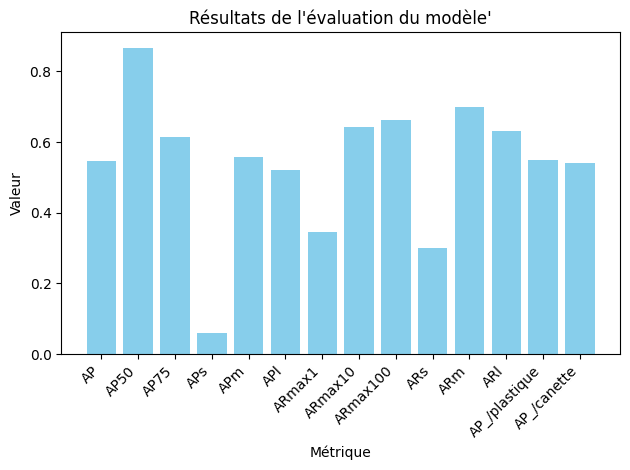

In [8]:
# https://cocodataset.org/#detection-eval
# val_loss, val_accuracy = model.evaluate(val_data)

evaluation = model.evaluate(val_data)

def plotEvaluation(eval, title="Résultats de l\'évaluation du modèle'"):
    import matplotlib.pyplot as plt
    plt.bar(eval.keys(), eval.values(), color='skyblue')
    plt.xlabel('Métrique')
    plt.ylabel('Valeur')
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plotEvaluation(evaluation)

## Export du modèle au format Tensorflow lite

In [16]:
config = QuantizationConfig.for_float16()
model.export(export_dir='bin/', 
             tflite_filename='greengardians.tflite'
             )
# model.export(export_dir='bin/', 
#              quantization_config=config,
#              export_format=[ExportFormat.SAVED_MODEL, ExportFormat.LABEL])


2024-04-15 23:44:21.629026: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.


Estimated count of arithmetic ops: 13.698 G  ops, equivalently 6.849 G  MACs


2024-04-15 23:44:40.107129: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2024-04-15 23:44:40.107212: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2024-04-15 23:44:40.119210: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp46kdjdig
2024-04-15 23:44:40.261314: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2024-04-15 23:44:40.261359: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmp46kdjdig
2024-04-15 23:44:40.835303: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-04-15 23:44:44.989119: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmp46kdjdig
2024-04-15 23:44:46.738340: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 6619147

Estimated count of arithmetic ops: 13.698 G  ops, equivalently 6.849 G  MACs


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 0
2024-04-15 23:47:22.112032: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:1963] Estimated count of arithmetic ops: 13.698 G  ops, equivalently 6.849 G  MACs



## Evaluation du modèle entrainé

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


16/16 [==============================] - 247s 15s/step



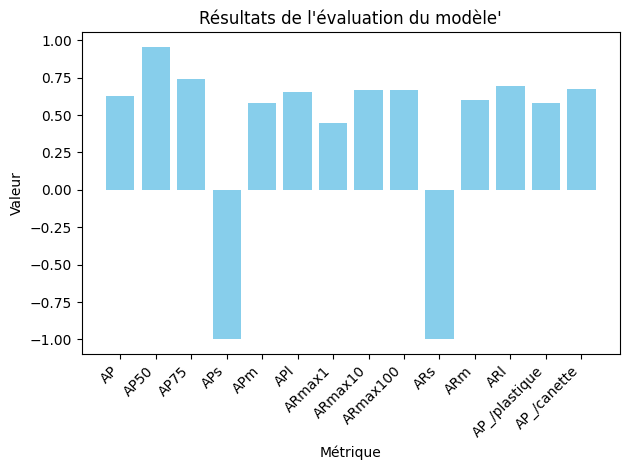

In [10]:
model_path = 'bin/greengardians.tflite'
evaluation_lite = model.evaluate_tflite(model_path, test_data)

plotEvaluation(evaluation_lite)

In [11]:
# NUMBER_OF_TPUS =  2

# !edgetpu_compiler 'bin/greengardians-full.tflite' --num_segments=$NUMBER_OF_TPUS

## Utilitaires

In [12]:
import cv2

from PIL import Image

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# classes = {0: "plastique", 1: "canette"}
print('classes', classes)

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)


  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])


  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results

def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  print('results', results)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

classes ['plastique', 'canette']


## Prediction

In [13]:
# Load the TFLite model
import os, random
from pathlib import Path
model_path = 'bin/greengardians.tflite'

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# # Run inference and draw detection result on the local copy of the original file
DETECTION_THRESHOLD = 0.5
          
PROJECT_FOLDER = Path(Path.cwd())
image_folder = str(PROJECT_FOLDER) + '/datasets/dataset.voc/test/'
# imageToPredict = 'datasets/dataset.voc/test/IMG_20231025_095509_jpg.rf.c83cb3628dda974ef28a37ce404b9ab7.jpg'
                                                          
l_detection_result_image = []
files = [image_folder +'/'+ f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# imageToPredict = 'datasets/dataset.voc/test/IMG_20231025_095509_jpg.rf.c83cb3628dda974ef28a37ce404b9ab7.jpg'
imageToPredict = random.choice(files)
print(imageToPredict)
detection_result_image = run_odt_and_draw_results(
        imageToPredict,
        interpreter,
        threshold=DETECTION_THRESHOLD
)
# for file in files:
#     detection_result_image = run_odt_and_draw_results(
#         file,
#         interpreter,
#         threshold=DETECTION_THRESHOLD
#     )
#     l_detection_result_image.append(detection_result_image)

/home/charles/web/alyra/villepropre/vp-server/train/datasets/dataset.voc/test//IMG_20231025_103617_jpg.rf.98326425a1fa8052f4e381a5ae21ac0c.jpg
results [{'bounding_box': array([0.20560214, 0.47219577, 0.66610086, 0.6672017 ], dtype=float32), 'class_id': 0.0, 'score': 0.9453125}, {'bounding_box': array([0.48055065, 0.30144843, 0.7475232 , 0.4242945 ], dtype=float32), 'class_id': 0.0, 'score': 0.94140625}, {'bounding_box': array([0.50175864, 0.74928457, 0.6908271 , 0.88603395], dtype=float32), 'class_id': 1.0, 'score': 0.91796875}, {'bounding_box': array([0.60110855, 0.6050622 , 0.79774106, 0.7201869 ], dtype=float32), 'class_id': 1.0, 'score': 0.91796875}, {'bounding_box': array([0.59620327, 0.42704123, 0.8063466 , 0.5213577 ], dtype=float32), 'class_id': 1.0, 'score': 0.9140625}]


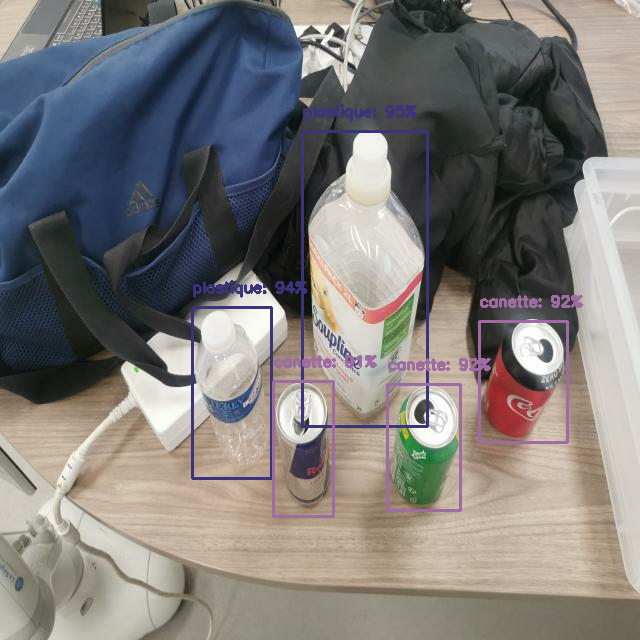

In [14]:
Image.fromarray(detection_result_image)

# import matplotlib.pyplot as plt
# plt.figure(figsize=(5, 5))
# plt.imshow(imageToPredict)
# plt.show()
# plt.close()
# test_validation_folder = str(PROJECT_FOLDER) + '/datasets/dataset.voc/test_val/'

# # Show all the detection result
# for image in l_detection_result_image:
#     plt.figure(figsize=(5, 5))
#     plt.imshow(image)
#     plt.show()
#     # Save the image in the validation folder    
#     plt.close()